# Notebook for results analysis of GAN training. 

In [1]:
#Import of necessary packages and memory allocation.
!export PATH=/softs/anaconda3/envs/tf1.12-cuda10-py36/bin/:$PATH
%matplotlib inline

import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(1)
set_session(tf.Session(config=config))
import time
import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import sys
import seaborn as sns
import math
from sklearn.decomposition import PCA
#s = np.random.seed(1)

Using TensorFlow backend.


In [2]:

import cartopy
import cartopy.crs as ccrs
import cartopy.util


## Loading Data

In [ ]:
#########
multi_train = True  #If the training was in multiple run : True
plot_var = True     #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

N_gen = 800      #Number of generation used for statistic analysis /!\ Memory usage important /!\
N_train = 800
#indxs = np.random.randint(0,1000,N_gen)
#ind = indxs[0]
#########
lons = np.genfromtxt(f'../data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt(f'../data/raw/lat.csv', delimiter=',')

print(lons)
lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']



if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save

sys.path.append('../src/modeling')

sys.path.append('../src/preprocessing')

sys.path.append('../src/preparation')
from SpectralNormalizationKeras import *
from custom_classes import *
from data_preproc import *


gen = load_model(f'{model_path}',custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})

print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')
print('Database loading...')

if N_fields==82:
    f=h5.File(f'{data_folder}T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])

print('Database loaded.')
print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

noise_ = np.load('../data/raw/noise_.npy')
im = gen.predict(noise_)
im_sc = np.multiply(im[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
X_train, lon = cartopy.util.add_cyclic_point(X_train, coord=lons, axis=2)
fk_imgs, lon = cartopy.util.add_cyclic_point(fk_imgs, coord=lons, axis=2)
im, lon = cartopy.util.add_cyclic_point(im, coord=lons, axis=2)
im_sc, lon = cartopy.util.add_cyclic_point(im_sc, coord=lons, axis=2)



[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 303.75   306.5

# Geostrophic Wind

## Wikipedia 
Le vent géostrophique se définit comme le vent qui résulterait de l'équilibre géostrophique entre la force de Coriolis et la force du gradient de pression atmosphérique agissant sur une parcelle d'air. Ce vent soufflerait parallèlement aux isobares dans l'atmosphère. La plus grande partie de l'écoulement atmosphérique, au-dessus de la couche limite en dehors des tropiques, est proche de l'équilibre géostrophique, ce qui en fait une approximation communément utilisée en météorologie. Toutefois, cet équilibre est rarement exact, en raison d'autres forces qui agissent sur le vent comme la friction (près du sol) ou la force centrifuge dans un écoulement courbé.

Le vent agéostrophique ($v_a)$ est la composante du vent total qui diffère de l'équilibre géostrophique $(v_g)^2$. Il est donc défini par3 : ${\displaystyle {\vec {v}}_{a}={\vec {v}}_{reel}-{\vec {v}}_{g}}{\displaystyle {\vec {v}}_{a}={\vec {v}}_{reel}-{\vec {v}}_{g}}$.

Les composantes agéostrophiques du vent à l'échelle synoptique sont relativement petites, et peuvent être négligées en première approximation dans un contexte diagnostique. Toutefois elles sont cruciales dans l'évolution future de l'écoulement car elles dénotent la présence de forçages qui créent de la convergence ou de la divergence dans l'écoulement, produisant ainsi le mouvement vertical à l'origine de plusieurs phénomènes météorologiques, dont les dépressions des latitudes moyennes4,5.

Près de la surface, l'effet de la friction entre l'air et la surface perturbe l'équilibre géostrophique. La friction ralentit l'écoulement, réduisant ainsi la force de Coriolis. Dans ce nouvel équilibre à trois forces, l'effet de la force de Coriolis n'est plus suffisant pour forcer l'écoulement à être parallèle aux isobares et une partie du mouvement résultant s'aligne vers la zone de basse pression. Ainsi, près de la surface, l'écoulement horizontal prend la forme d'une spirale convergente vers le centre des dépressions et divergente du centre des anticyclones et donne la spirale d'Ekman.

Finalement d'autres effets s'ajoutent dont la composante isallobarique due au déplacement et au creusement du système météorologique, le vent de gradient dans les vallées, etc.

[[1 2 3]
 [4 5 6]]
[1 2 3]
[[3. 3. 3.]
 [3. 3. 3.]] [[1. 1. 1.]
 [1. 1. 1.]]


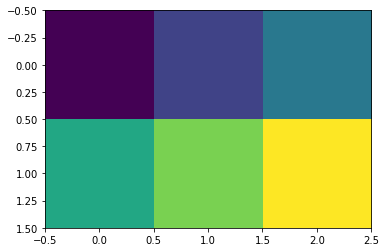

In [4]:
x = np.array([[1,2,3], [4,5,6]])
print(x)
print(x[0,:])
[gx, gy] = np.gradient(x)
print(gx, gy)

plt.figure()
plt.imshow(x)

On néglige l'effet de la friction, ce qui est permis à une très bonne approximation à l'échelle synoptique dans l'atmosphère libre aux latitudes moyennes. On néglige aussi la composante agéostrophique décrite plus haut qui est due aux différents facteurs décrits.

On peut obtenir le vent géostrophique ${\displaystyle (u_{g},v_{g})}{\displaystyle (u_{g},v_{g})}$ des équations primitives atmosphériques en utilisant l'approximation quasi-géostrophique6 :

${\displaystyle u_{g}=-{g \over f}{\partial Z \over \partial y}}$ ; 
${\displaystyle v_{g}={g \over f}{\partial Z \over \partial x}}$
Où g est l'accélération gravitationnelle (9,81 m s−2), f est le paramètre de Coriolis (variable avec la latitude), et Z est la hauteur géopotentielle. La validité de cette approximation dépend du nombre de Rossby à l'endroit où on veut l'appliquer. Elle est invalide à l'équateur car f y est égal à zéro. On évite généralement d'utiliser cette approximation dans les tropiques.

D'autres variantes de cette équation existent, par exemple en utilisant le champ de pression au lieu de Z. Dans ce cas, l'expression est un peu plus complexe.

In [5]:
def geo_wind_explained(geopot1, geopot2, lon, lat, atm_lvl, scale=10, lvls=10, extent=None):
    geopot, lons = cartopy.util.add_cyclic_point(geopot1, coord=lon, axis=2)
    geopot = geopot
    phi, theta = np.meshgrid(lons,lats)
    #print('latitude', theta)
    
    #Geopotential gradient
    dz = np.gradient(geopot[ind,:,:,70+atm_lvl], lats, lons) # 0: dtheta 1:dphi
    
    plt.figure()
    plt.imshow(dz[0])
    plt.colorbar()
    
    plt.figure()
    plt.imshow(dz[1])
    plt.colorbar()
    #print(dz[0].shape)
    r=6.7e6
    
    dzdtheta, dzdphi = dz[0]*1./r, dz[1]*1./(np.cos(np.pi-theta*np.pi/180.)*r)
    print('dzdtheta')
    plt.figure()
    plt.imshow(dzdtheta)
    plt.colorbar()
    
    print('dzdphi')
    plt.figure()
    plt.imshow(dzdphi)
    plt.colorbar()
    
    dzdr = np.zeros((dzdtheta.shape))
    gradz = np.concatenate((np.expand_dims(dzdr, axis=0), np.expand_dims(dzdtheta, axis=0), np.expand_dims(dzdphi, axis=0)), axis=0)
    k = np.zeros((gradz.shape))


    
    k[0,:,:] = 1.
    f = 2.*7.2921e-5*np.sin(theta*np.pi/180.)#*57.9
    print('f')
    plt.figure()
    plt.imshow(f)
    plt.colorbar()
    #print(f)
    
    
    plt.figure()
    plt.imshow(geopot[ind,:,:,20+atm_lvl]/(f*1000))
    plt.colorbar()
    
    res=np.zeros((3,64,129))
    #for i in range(64):
        #for j in range(129):
            #res[:,i,j] = (1./f[i,j])*np.cross(k[:,i,j],gradz[:,i,j])
            #print(9.81/f[i,j]*np.cross(k[:,i,j],gradz[:,i,j]))
    res[1,:,:] = -dzdphi/f*9.81
    res[2,:,:] = dzdtheta/f*9.81
    u_wind = geopot[ind,:,:,10+atm_lvl]
    v_wind = geopot[ind,:,:,20+atm_lvl]
    ageo_wind_u = np.asarray(u_wind) - np.asarray(res[1,:,:])
    ageo_wind_v = np.asarray(v_wind) - np.asarray(res[2,:,:])
    geo_wind_u = res[1,:,:]
    geo_wind_v = res[2,:,:]
    print('mean res', np.mean(res[1,:,:]), np.mean(res[2,:,:]))
    print('mean res', np.mean(u_wind), np.mean(v_wind))
    lon_2d, lat_2d = np.meshgrid(lons, lats)
    quiver_slices = (slice(None, None, 3), slice(None, None, 3))
    quiver_kwargs = {'headlength': 3, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': scale}
    quiver_kwargs2 = {'headlength': 3, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': scale}
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
    plt.subplots_adjust(top=0.9, bottom=0.001,right=0.89, left=0.1, wspace=0.1, hspace=0.1)
    axc=ax[0]
    axc.set_extent(extent, crs=ccrs.PlateCarree())
    axc.coastlines(linewidth = 3.)
    axc.set_title('(a)', fontsize = 18)
    cim1 = axc.contour(lons, lats, geopot[ind,:,:,70+atm_lvl], levels = lvls, cmap = 'viridis', linewidth=(7,),
                       transform=ccrs.PlateCarree(central_longitude=360.))


    alpha = 1.
    geo = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                    geo_wind_u[quiver_slices], geo_wind_v[quiver_slices], alpha=alpha,
                    color='darkorchid', **quiver_kwargs2, transform=ccrs.PlateCarree(central_longitude=360.))
    
    ageo = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                     ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices], alpha=alpha,
                     color='red', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))
    
    wind = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices], alpha=alpha,
                 color='blue', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))
    
    axc.legend([geo,ageo,wind],['Geostrophic wind', 'Ageostrophic wind','wind'], loc=6,
               bbox_to_anchor=(1.0, -0.15, 0., 0.), fontsize = 16)
    
    
    posn1 = axc.get_position()
    #cax21 = fig.add_axes([posn1.x0 - 2*0.008, posn1.y0, 0.008, posn1.height])
    #cbar = plt.colorbar(cim1, cax = cax21)
    #cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    #cax21.yaxis.set_ticks_position('left')
    norm_w = np.sqrt(u_wind**2+v_wind**2)
    norm_g = np.sqrt(geo_wind_u**2+geo_wind_v**2)
    norm_a = np.sqrt(ageo_wind_u**2+ageo_wind_v**2)
    
    relative_err1 = (norm_a)/(norm_w)
    
    print('mean relative error1 per pixel : ',np.mean(relative_err1[16,:]))
    
    geopot, lons = cartopy.util.add_cyclic_point(geopot2, coord=lon, axis=2)
    phi, theta = np.meshgrid(lons,lats)
    dz = np.gradient(geopot[0,:,:,70+atm_lvl], lats, lons) # 0: dtheta 1:dphi
    dzdtheta, dzdphi = dz[1]*1./r, dz[0]*1./(np.sin(theta*np.pi/180.)*r)
    dzdr = np.zeros((dzdtheta.shape))
    gradz = np.concatenate((np.expand_dims(dzdr, axis=0), np.expand_dims(dzdtheta, axis=0), np.expand_dims(dzdphi, axis=0)), axis=0)
    k = np.zeros((gradz.shape))
    k[0,:,:] = 1.
    f = 2.*7.2921e-5*np.sin(theta*np.pi/180.)#*57.9
    
    res=np.zeros((3,64,129))
    for i in range(64):
        for j in range(129):
            res[:,i,j] = (1./f[i,j])*np.cross(k[:,i,j],gradz[:,i,j])
    u_wind = geopot[0,:,:,10+atm_lvl]
    v_wind = geopot[0,:,:,20+atm_lvl]
    ageo_wind_u = np.asarray(u_wind) - np.asarray(res[1,:,:])
    ageo_wind_v = np.asarray(v_wind) - np.asarray(res[2,:,:])
    geo_wind_u = res[1,:,:]
    geo_wind_v = res[2,:,:]
    lon_2d, lat_2d = np.meshgrid(lons, lats)
    #print('mean res', np.mean(res[1,:,:]), np.mean(res[2,:,:]))
    #print('mean res', np.mean(u_wind), np.mean(v_wind))
    
    axc=ax[1]
    axc.set_extent(extent, crs=ccrs.PlateCarree())
    axc.coastlines(linewidth = 1.)
    axc.set_title('(b)', fontsize = 18)
    cim2 = axc.contour(lons, lats, geopot[0,:,:,70+atm_lvl], levels = cim1.levels, cmap = 'viridis', linewidth=2.,
                       transform=ccrs.PlateCarree(central_longitude=360.))
    #cim2 = axc.contourf(lons, lats, geopot[0,:,:,70+atm_lvl], levels = lvls, cmap = 'viridis', linewidth=7,
    #                   transform=ccrs.PlateCarree(central_longitude=360.), alpha=0.1)
    #magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
    #sp = axc.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'Reds',
    #               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.95, density=2.5, color=magnitude)
    #im1 = sp.lines

    ageo = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                     ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices], alpha=alpha*0.,
                     color='red', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))

    geo = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                    geo_wind_u[quiver_slices], geo_wind_v[quiver_slices], alpha=alpha,
                    color='darkorchid', **quiver_kwargs2, transform=ccrs.PlateCarree(central_longitude=360.))
    
    wind = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                     u_wind[quiver_slices], v_wind[quiver_slices], alpha=alpha*0,
                     color='blue', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))
    #axc.legend([geo,ageo,wind],['Geostrophic wind', 'Ageostrophic wind','wind'])
    
    
    posn2 = axc.get_position()
    cax22 = fig.add_axes([posn2.x0 - 3*0.008, posn2.y0, 2*0.008, 2.25*posn1.height])
    cbar = plt.colorbar(cim1, cax = cax22)
    plt.suptitle("Geopotential and wind with \n geostrophic and ageostrophic components at z400", fontsize=19,
                fontweight='bold')
    #cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    cax22.yaxis.set_ticks_position('left')
    norm_w = np.sqrt(u_wind**2+v_wind**2)
    norm_g = np.sqrt(geo_wind_u**2+geo_wind_v**2)
    norm_a = np.sqrt(ageo_wind_u**2+ageo_wind_v**2)
    
    relative_err2 = norm_a/(norm_w)
    
    print('mean relative error2 per pixel : ',np.mean(relative_err2))
    
    plt.savefig('./fig_82c/quiver_winds.pdf')  
    return relative_err1, relative_err2, res


In [6]:
def geo_wind_explained_rep(geopot1, geopot2, lon, lat, atm_lvl, scale=10, lvls=10, extent=None):
    geopot, lons = cartopy.util.add_cyclic_point(geopot1, coord=lon, axis=2)
    geopot = geopot
    
    #Phi : longitudes, theta:latitudes
    phi, theta = np.meshgrid(lons,lats)
    
    dz = np.gradient(geopot[ind,:,:,70+atm_lvl], lats, lons) # 0: dlat 1:dlon

    #Spherical gradient
    r=15e3
    #r=6.7e6
    dzdtheta, dzdphi = dz[0]*1./r, dz[1]*1./(np.sin(np.pi+theta*np.pi/180.)*r)
    dzdr = np.zeros((dzdtheta.shape))
    gradz = np.concatenate((np.expand_dims(dzdr, axis=0), np.expand_dims(dzdtheta, axis=0), np.expand_dims(dzdphi, axis=0)), axis=0)

    #Normal vector
    k = np.zeros((gradz.shape))
    k[0,:,:] = 1.
    
    #Coriolis coefficient
    f = 2.*7.2921e-5*np.sin(theta*np.pi/180.)#*57.9

    res=np.zeros((3,64,129))
    for i in range(64):
        for j in range(129):
            res[:,i,j] = (1./f[i,j])*np.cross(k[:,i,j],gradz[:,i,j])

    geo_wind_u = -res[2,:,:]
    geo_wind_v = res[1,:,:]
    u_wind = geopot[ind,:,:,10+atm_lvl]
    v_wind = geopot[ind,:,:,20+atm_lvl]
    ageo_wind_u = u_wind - geo_wind_u
    ageo_wind_v = v_wind - geo_wind_v

    lon_2d, lat_2d = np.meshgrid(lons, lats)
    
    quiver_slices = (slice(None, None, 3), slice(None, None, 3))
    quiver_kwargs = {'headlength': 3, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': scale}
    quiver_kwargs2 = {'headlength': 3, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': scale}
    
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(25,25),
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
    plt.subplots_adjust(top=0.85, bottom=0.1,right=0.85, left=0.15, wspace=0.1, hspace=0.001)
    axc=ax[0]
    axc.set_extent(extent, crs=ccrs.PlateCarree())
    axc.coastlines(linewidth = 3.)
    axc.set_title('(a)', fontsize = 35)
    cim1 = axc.contour(lons, lats, geopot[ind,:,:,70+atm_lvl], levels = lvls, cmap = 'viridis', linewidth=(7,),
                       transform=ccrs.PlateCarree(central_longitude=360.))
    lat_clip = 18
    alpha = 1.
    geo = axc.quiver(lon_2d[:lat_clip:3,::3], lat_2d[:lat_clip:3,::3],
                    geo_wind_u[:lat_clip:3,::3], geo_wind_v[:lat_clip:3,::3], alpha=alpha,
                    color='darkorchid', **quiver_kwargs2, transform=ccrs.PlateCarree(central_longitude=360.), target_extent=extent)
    
    ageo = axc.quiver(lon_2d[:lat_clip:3,::3], lat_2d[:lat_clip:3,::3],
                     ageo_wind_u[:lat_clip:3,::3], ageo_wind_v[:lat_clip:3,::3], alpha=alpha,
                     color='red', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.), target_extent=extent)
    
    wind = axc.quiver(lon_2d[:lat_clip:3,::3], lat_2d[:lat_clip:3,::3],
                 u_wind[:lat_clip:3,::3], v_wind[:lat_clip:3,::3], alpha=alpha,
                 color='blue', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.), target_extent=extent)

    posn1 = axc.get_position()

    norm_w = np.sqrt(u_wind**2+v_wind**2)
    norm_g = np.sqrt(geo_wind_u**2+geo_wind_v**2)
    norm_a = np.sqrt(ageo_wind_u**2+ageo_wind_v**2)
    
    
    norm_rossbydm = np.sqrt((u_wind - geo_wind_u)**2 + (v_wind - geo_wind_v)**2)/norm_w
    
    dp = np.zeros((64, 129))
    for i in range(64):
        for j in range(129):
            dp[i,j] = np.dot([0, u_wind[i,j], v_wind[i,j]], [0, ageo_wind_u[i,j], ageo_wind_v[i,j]])/norm_w[i,j]**2
            
    print('Rossby : ',np.mean(norm_rossbydm[25,:30]))
    relative_err1a = (norm_a-norm_w)/(norm_w)
    relative_err1g = (norm_g)/(norm_w)
    
    print('mean relative error1 per pixel a : ',np.mean(relative_err1a[20,:]))
    print('mean relative error1 per pixel g : ',np.mean(relative_err1g[20,:]))
    
    geopot, lons = cartopy.util.add_cyclic_point(geopot2, coord=lon, axis=2)
    phi, theta = np.meshgrid(lons,lats)
    dz = np.gradient(geopot[0,:,:,70+atm_lvl], lats, lons) # 0: dtheta 1:dphi
    dzdtheta, dzdphi = dz[0]*1./r, dz[1]*1./(np.sin(np.pi+theta*np.pi/180.)*r)
    
    dzdr = np.zeros((dzdtheta.shape))
    gradz = np.concatenate((np.expand_dims(dzdr, axis=0), np.expand_dims(dzdtheta, axis=0), np.expand_dims(dzdphi, axis=0)), axis=0)
    
    res=np.zeros((3,64,129))
    for i in range(64):
        for j in range(129):
            res[:,i,j] = (1./f[i,j])*np.cross(k[:,i,j],gradz[:,i,j])

    geo_wind_u = -res[2,:,:]
    geo_wind_v = res[1,:,:]
    u_wind = geopot[0,:,:,10+atm_lvl]
    v_wind = geopot[0,:,:,20+atm_lvl]
    ageo_wind_u = u_wind - geo_wind_u
    ageo_wind_v = v_wind - geo_wind_v
    lon_2d, lat_2d = np.meshgrid(lons, lats)

    axc=ax[1]
    axc.set_extent(extent, crs=ccrs.PlateCarree())
    axc.coastlines(linewidth = 3.)
    axc.set_title('(b)', fontsize = 35)
    cim2 = axc.contour(lons, lats, geopot[0,:,:,70+atm_lvl], levels = cim1.levels, cmap = 'viridis', linewidth=2.,
                       transform=ccrs.PlateCarree(central_longitude=360.))
    lat_clip=18
    ageo = axc.quiver(lon_2d[:lat_clip:3,::3], lat_2d[:lat_clip:3,::3],
                     ageo_wind_u[:lat_clip:3,::3], ageo_wind_v[:lat_clip:3,::3], alpha=alpha,
                     color='red', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.), target_extent=extent)

    geo = axc.quiver(lon_2d[:lat_clip:3,::3], lat_2d[:lat_clip:3,::3],
                    geo_wind_u[:lat_clip:3,::3], geo_wind_v[:lat_clip:3,::3], alpha=alpha,
                    color='darkorchid', **quiver_kwargs2, transform=ccrs.PlateCarree(central_longitude=360.), target_extent=extent)

    wind = axc.quiver(lon_2d[:lat_clip:3,::3], lat_2d[:lat_clip:3,::3],
                     u_wind[:lat_clip:3,::3], v_wind[:lat_clip:3,::3], alpha=alpha,
                     color='blue', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.), target_extent=extent)
    
    #axc.legend([geo,ageo,wind],['Geostrophic wind', 'Ageostrophic wind','wind'], loc=6,
    #           bbox_to_anchor=(1.0, 1.15, 0., 0.), fontsize = 16)
    plt.legend([geo,ageo,wind],['Geostrophic wind', 'Ageostrophic wind','wind'],
               bbox_to_anchor=(0.7, 2.5, 0., 0.), loc='upper left', fontsize = 20)
    posn2 = axc.get_position()
    cax22 = fig.add_axes([posn2.x0-0.036, posn2.y0, 2*0.008, 2.2*posn1.height])
    cbar = plt.colorbar(cim1, cax = cax22)
    cbar.ax.tick_params(labelsize=30)
    plt.suptitle("Geopotential and wind with \n geostrophic and ageostrophic components at z100", fontsize=29,
                fontweight='bold')
    cax22.yaxis.set_ticks_position('left')
    norm_w = np.sqrt(u_wind**2+v_wind**2)
    norm_g = np.sqrt(geo_wind_u**2+geo_wind_v**2)
    norm_a = np.sqrt(ageo_wind_u**2+ageo_wind_v**2)
    
    relative_err2a = (norm_a-norm_w)/(norm_w)
    relative_err2g = (norm_g)/(norm_w)
    norm_rossbydm2 = np.sqrt((u_wind - geo_wind_u)**2 + (v_wind - geo_wind_v)**2)/norm_w
    
    print('mean relative error2 per pixel a ',np.mean(relative_err2a[20,:]))
    print('mean relative error2 per pixel g ',np.mean(relative_err2g[20,:]))
    
    dp2 = np.zeros((64, 129))
    for i in range(64):
        for j in range(129):
            dp2[i,j] = np.dot([0, u_wind[i,j], v_wind[i,j]], [0, ageo_wind_u[i,j], ageo_wind_v[i,j]])/norm_w[i,j]**2
            
    print('mean relative error1 per pixel a : ',np.mean(dp2[25,:]))
    #plt.tight_layout()
    plt.savefig('./fig_82c/quiver_winds.pdf')  
    return relative_err1a, relative_err1g, relative_err2a, relative_err2g, res, dp, dp2, norm_rossbydm, norm_rossbydm2


(64, 129) 129
[[ 87.86379884  87.86379884  87.86379884 ...  87.86379884  87.86379884
   87.86379884]
 [ 85.09652699  85.09652699  85.09652699 ...  85.09652699  85.09652699
   85.09652699]
 [ 82.31291295  82.31291295  82.31291295 ...  82.31291295  82.31291295
   82.31291295]
 ...
 [-82.31291295 -82.31291295 -82.31291295 ... -82.31291295 -82.31291295
  -82.31291295]
 [-85.09652699 -85.09652699 -85.09652699 ... -85.09652699 -85.09652699
  -85.09652699]
 [-87.86379884 -87.86379884 -87.86379884 ... -87.86379884 -87.86379884
  -87.86379884]] (64, 129)


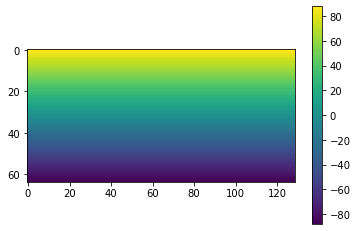

In [8]:
ind = 4115
lons = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
lons_n = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
lats = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')

geopot, lons = cartopy.util.add_cyclic_point(X_train[ind,:,:,74], coord=lons, axis=1)
print(geopot.shape, len(lons))
phi, theta = np.meshgrid(lons,lats)
print(theta, phi.shape)

plt.imshow(theta)
plt.colorbar()

In [9]:
noise_ = np.load('./fig_82c/noise_.npy')
im = gen.predict(noise_)
image = np.multiply(im[:,:,:,:-1],
                          scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
image.shape
#im_sc = np.multiply(im[:,:,:,:-1],
#                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]

(1, 64, 128, 81)

/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Rossby :  1.620671893127556
mean relative error1 per pixel a :  -0.46353417596466917
mean relative error1 per pixel g :  1.000095947831397
mean relative error2 per pixel a  0.6293634674064964
mean relative error2 per pixel g  1.8410902698383351
mean relative error1 per pixel a :  -0.7345443570838439


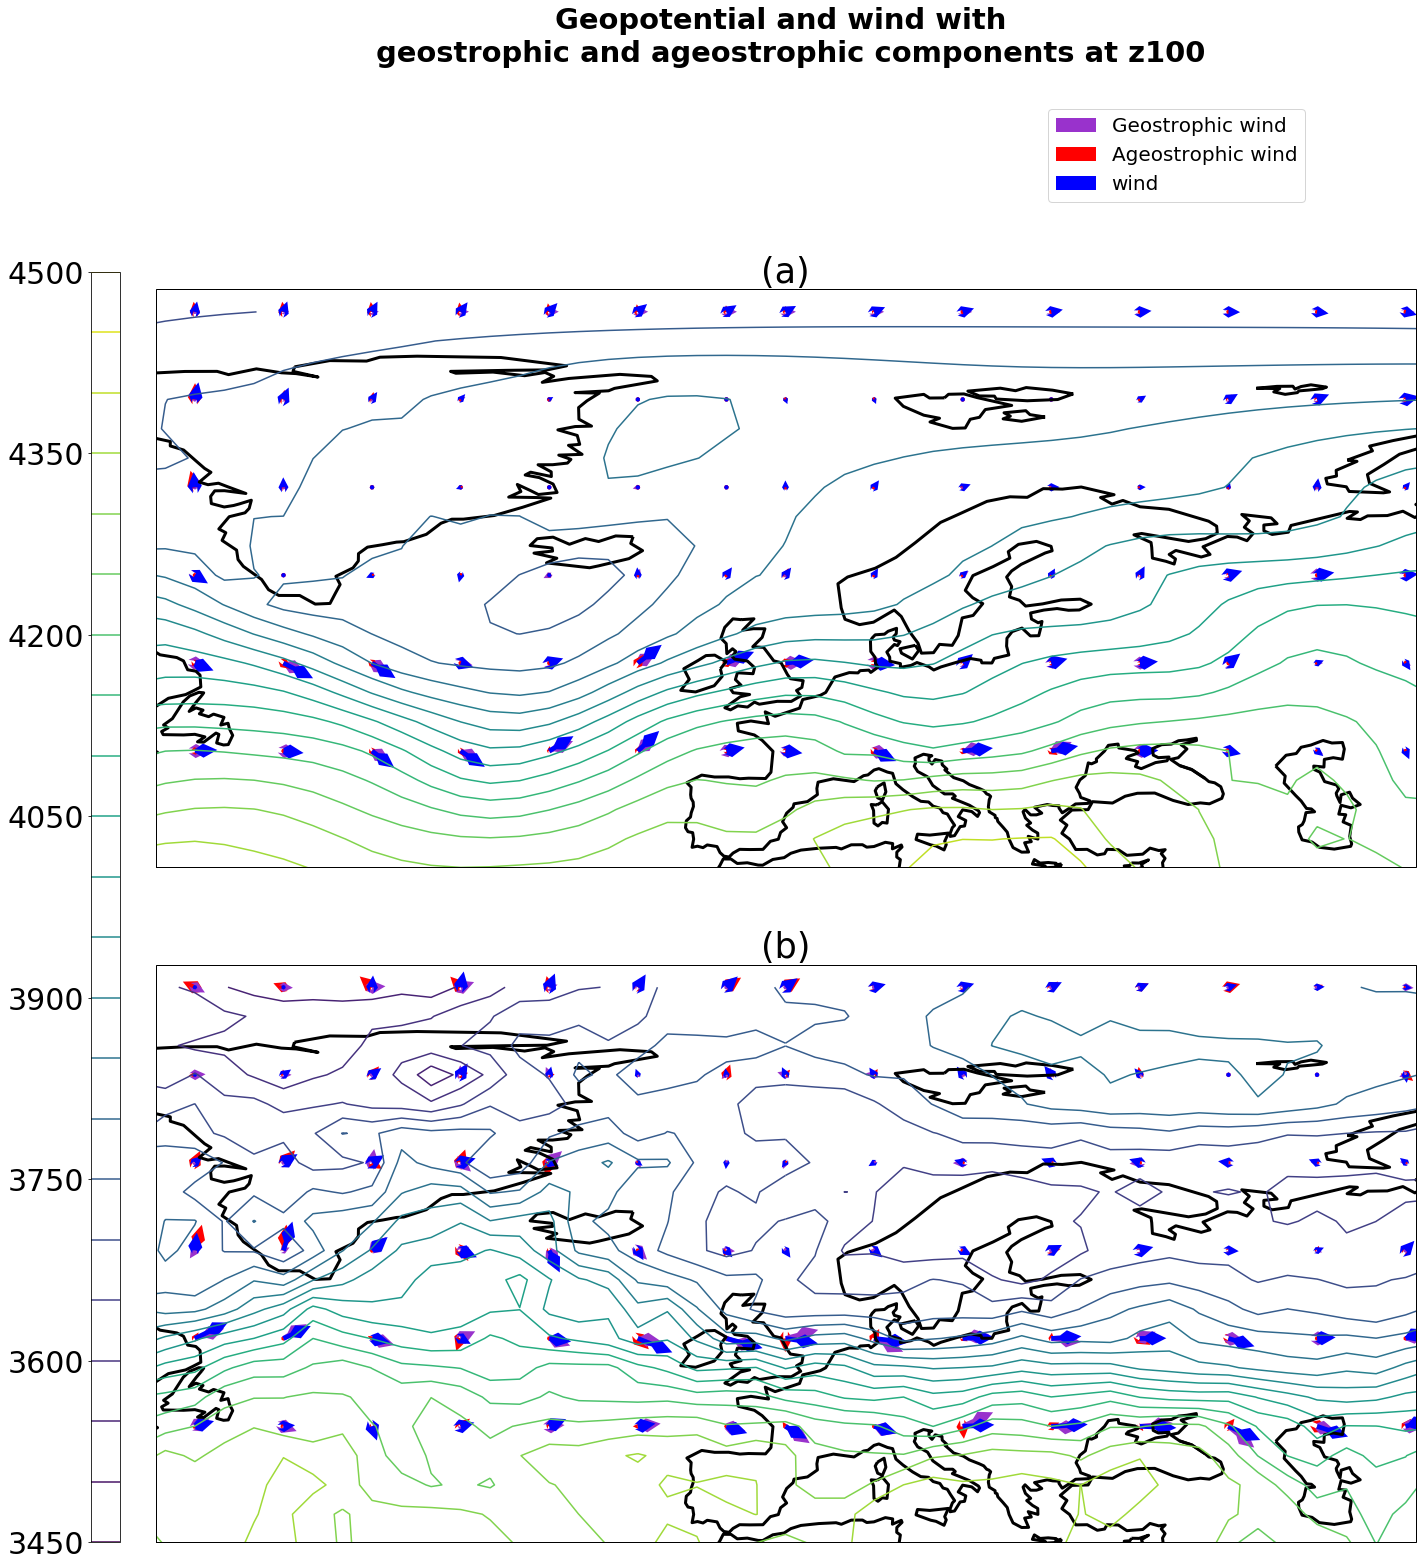

In [10]:
lon = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')

re1a, re1g, re2a, re2g, geo_wind, dp, dp2, RO, RO2 = geo_wind_explained_rep(X_train, image, lon, lat, atm_lvl=5,
                                            scale=9, lvls=20, extent=[-60, 60, 35, 90])

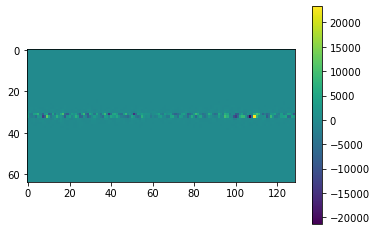

In [11]:
plt.imshow(geo_wind[1,:,:])
plt.colorbar()

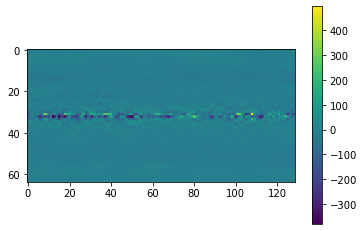

In [12]:
plt.imshow(geo_wind[2,:,:])
plt.colorbar()

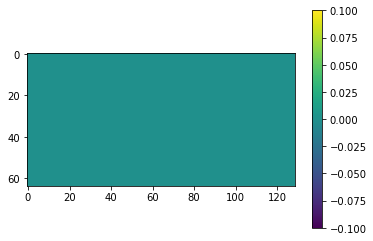

In [13]:
plt.imshow(geo_wind[0,:,:])
plt.colorbar()

/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


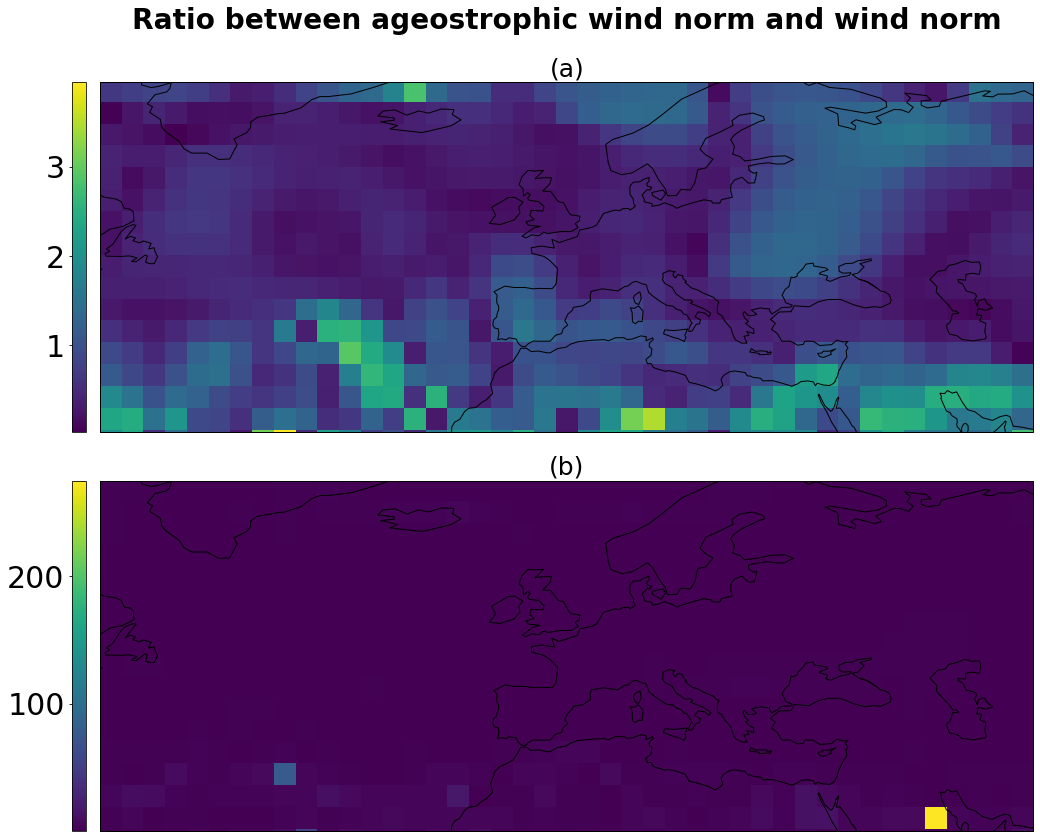

In [14]:
#fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(15,20),
#                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
#ax=axs[0]
#ax.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
#ax.coastlines(linewidth = 1.)
#im = ax.contourf(lons, lats, re1, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))
#posn = ax.get_position()
#cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
#cbar = plt.colorbar(im, cax = cax21)
#cax21.yaxis.set_ticks_position('left')
#plt.grid(False)
#
#ax=axs[1]
#ax.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
#ax.coastlines(linewidth = 1.)
#im2 = ax.contourf(lons, lats, re2, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))
#posn = ax.get_position()
#cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
#cbar = plt.colorbar(im2, cax = cax21)
#cax21.yaxis.set_ticks_position('left')
#plt.grid(False)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(25,13),
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
plt.suptitle('Ratio between ageostrophic wind norm and wind norm', fontsize = 28, fontweight='bold')
plt.subplots_adjust(top=0.9, bottom=0.1,right=0.85, left=0.15, wspace=0.1, hspace=0.14)
ax=axs[0]
ax.set_title('(a)', fontsize=25)
ax.set_extent([-60, 60, 25, 70], crs=ccrs.PlateCarree())
ax.coastlines(linewidth = 1.)
im = ax.imshow( RO, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))#, vmax=5)
posn = ax.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im, cax = cax21)
cbar.ax.tick_params(labelsize=30)
cax21.yaxis.set_ticks_position('left')
plt.grid(False)

ax=axs[1]
ax.set_title('(b)', fontsize=25)
ax.set_extent([-60, 60, 25, 70], crs=ccrs.PlateCarree())
ax.coastlines(linewidth = 1.)
im2 = ax.imshow( RO2, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))#, vmax=5)
posn = ax.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im2, cax = cax21)
cbar.ax.tick_params(labelsize=30)
cax21.yaxis.set_ticks_position('left')
plt.grid(False)
plt.tight_layout()
plt.savefig('./fig_82c/relative_err_norm_winds.pdf')  

/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


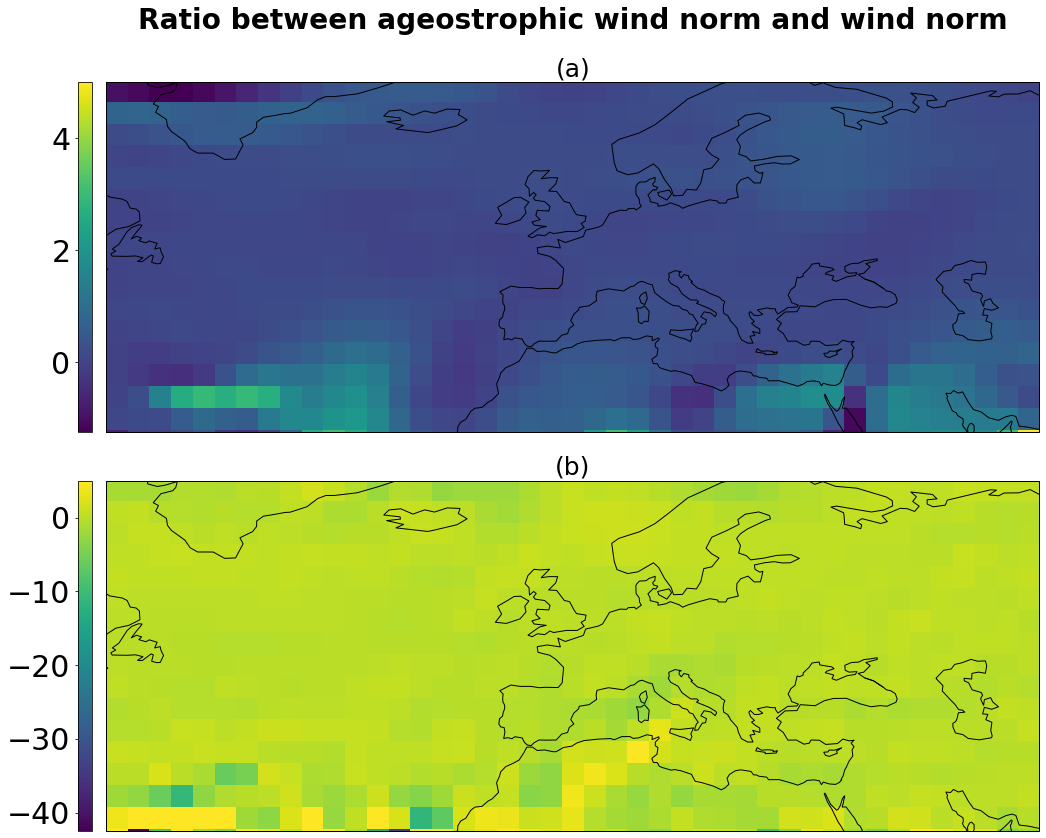

In [43]:
#fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(15,20),
#                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
#ax=axs[0]
#ax.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
#ax.coastlines(linewidth = 1.)
#im = ax.contourf(lons, lats, re1, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))
#posn = ax.get_position()
#cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
#cbar = plt.colorbar(im, cax = cax21)
#cax21.yaxis.set_ticks_position('left')
#plt.grid(False)
#
#ax=axs[1]
#ax.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
#ax.coastlines(linewidth = 1.)
#im2 = ax.contourf(lons, lats, re2, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))
#posn = ax.get_position()
#cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
#cbar = plt.colorbar(im2, cax = cax21)
#cax21.yaxis.set_ticks_position('left')
#plt.grid(False)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(25,13),
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
plt.suptitle('Ratio between ageostrophic wind norm and wind norm', fontsize = 28, fontweight='bold')
plt.subplots_adjust(top=0.9, bottom=0.1,right=0.85, left=0.15, wspace=0.1, hspace=0.14)
ax=axs[0]
ax.set_title('(a)', fontsize=25)
ax.set_extent([-60, 60, 25, 70], crs=ccrs.PlateCarree())
ax.coastlines(linewidth = 1.)
im = ax.imshow( dp, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.), vmax=5)
posn = ax.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im, cax = cax21)
cbar.ax.tick_params(labelsize=30)
cax21.yaxis.set_ticks_position('left')
plt.grid(False)

ax=axs[1]
ax.set_title('(b)', fontsize=25)
ax.set_extent([-60, 60, 25, 70], crs=ccrs.PlateCarree())
ax.coastlines(linewidth = 1.)
im2 = ax.imshow( dp2, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.), vmax=5)
posn = ax.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im2, cax = cax21)
cbar.ax.tick_params(labelsize=30)
cax21.yaxis.set_ticks_position('left')
plt.grid(False)
plt.tight_layout()
plt.savefig('./fig_82c/relative_err_norm_winds.pdf')  

In [515]:
dz = np.gradient(geopot, lats, lons) # 0: dphi 1:dtheta
r=1.

In [ ]:
plt.figure()
plt.imshow(dz[0])
plt.colorbar()
plt.figure()
plt.imshow(dz[1])
plt.colorbar()

In [ ]:
dzdtheta, dzdphi = dz[1]*1./r, dz[0]*1./(np.sin(theta+1e-2))
dzdr = np.zeros((dzdtheta.shape))

In [ ]:
plt.figure()
plt.imshow(dzdtheta)
plt.colorbar()
plt.figure()
plt.imshow(dzdphi[:,:])
plt.colorbar()

plt.figure()
plt.plot(1./np.sin(lats))

In [ ]:
gradz = np.concatenate((np.expand_dims(dzdr, axis=0), np.expand_dims(dzdtheta, axis=0), np.expand_dims(dzdphi, axis=0)), axis=0)
print(gradz.shape)
k = np.zeros((gradz.shape))
k[0,:,:] = 1.
print(gradz.shape)

In [ ]:
f = 1.
res=np.zeros((3,64,129))
for i in range(64):
    for j in range(129):
        res[:,i,j] = np.cross(k[:,i,j],gradz[:,i,j])
print(np.mean(res, axis=(1,2)))
print(res[0].shape)
print(res[1].shape)
print(res[2].shape)

In [ ]:
u_wind = cartopy.util.add_cyclic_point(X_train[ind,:,:,14], coord=lons_n, axis=1)[0]
v_wind = cartopy.util.add_cyclic_point(X_train[ind,:,:,24], coord=lons_n, axis=1)[0]
ageo_wind_u = np.asarray(u_wind) - np.asarray(res[1,:,:])
ageo_wind_v = np.asarray(v_wind) - np.asarray(res[2,:,:])
geo_wind_u = res[1,:,:]
geo_wind_v = res[2,:,:]

print(geo_wind_u.shape)
print(geo_wind_v.shape)
print(u_wind.shape)
print(v_wind.shape)
print(ageo_wind_u.shape)
print(ageo_wind_v.shape)

#geopot, lons = cartopy.util.add_cyclic_point(X_train[ind,:,:,74], coord=lons, axis=1)


#u_windg, v_windg = np.mean(fk_imgs[:,:,:,field-60], axis=0), np.mean(fk_imgs[:,:,:,field-50], axis=0)
#ageo_wind_ug = np.asarray(u_windg) - np.asarray(geo_wind_ug)
#ageo_wind_vg = np.asarray(v_windg) - np.asarray(geo_wind_vg)

In [ ]:
print(type(geo_wind_u))
plt.figure()
plt.imshow(geo_wind_u)
plt.colorbar()

plt.figure()
plt.imshow(geo_wind_v)
plt.colorbar()

plt.figure()
plt.hist(geo_wind_u.reshape(-1), bins=100)

In [ ]:
X = res
lon_2d, lat_2d = np.meshgrid(lons, lats)
print(lon_2d.shape)
print(lat_2d.shape)

fig = plt.figure(figsize=(15, 10))

# Add the map and set the extent
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-105., -93., 35., 43.])
#ax.background_patch.set_fill(False)

# Add state boundaries to plot
#ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the heights every 10 m
#contours = np.arange(10, 200, 10)
#c = plt.contour(lons, lats, np.mean(X[:,:,:], axis=0), levels=15,
#               colors='red', linewidths=1)
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 3, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 1}

# Plot the wind vectors

fig = plt.figure(figsize=(15, 10))
geo = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs)
fig = plt.figure(figsize=(15, 10))
ageo = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs)
fig = plt.figure(figsize=(15, 10))
wind = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs)
plt.legend(['wind', 'Geostrophic wind', 'Ageostrophic wind'])
# Add a title to the plot
#plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \n'
#          'Ageostrophic Wind(green) for {0:%d %B %Y %H:%MZ}'.format(time),
#          color='white', size=14)
#plt.savefig('./fig_82c/geo_wind.pdf')
plt.show()

In [ ]:
ind = 4115

fig, axc = plt.subplots(nrows = 1, ncols = 1, figsize=(15,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})

#ax = ax.reshape(-1)
#fig.suptitle(f'Geostrophic wind (z800)', fontsize = 24, fontweight = fontweight)
#fig.subplots_adjust(left=0.1,right=.9, wspace = 0.35, hspace = 0.2)


#axc = ax[0]
axc.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
axc.coastlines(linewidth = 1.)
axc.set_title('(a)', fontsize = 18)
cim1 = axc.contourf(lons, lats, geopot, levels = 8, cmap = 'viridis',
                   transform=ccrs.PlateCarree(central_longitude=360.))

#magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
#sp = axc.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'Reds',
#               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.95, density=2.5, color=magnitude)
#im1 = sp.lines

geo = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))

ageo = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))

wind = axc.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs, transform=ccrs.PlateCarree(central_longitude=360.))

axc.legend([geo,ageo,wind],['Geostrophic wind', 'Ageostrophic wind','wind'])


posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim1, cax = cax21)
#cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax21.yaxis.set_ticks_position('left')


#axc = plt.subplot(212)
#axc2 = ax[1]
#axc2.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
#axc2.set_title('(b)', fontsize = 18)
##axc = [1].axes(projection=ccrs.PlateCarree(central_longitude=0.))
#axc2.coastlines(linewidth = 1.)
#cim2 = axc2.contourf(lon, lat, im[0,:,:,temp_idx]*scaling[temp_idx,1]+scaling[temp_idx,0], vmin=gmin, vmax=gmax,
#                     levels = cim1.levels, cmap = 'viridis', transform=ccrs.PlateCarree(central_longitude=360.))
#
#magnitude = (im[0,:,:,wind_idx] ** 2 + im[0,:,:,wind_idx+N_lvls] ** 2) ** 0.5
#sp = axc2.streamplot(lon,lat, im[0,:,:,wind_idx], im[0,:,:,wind_idx+N_lvls], cmap = 'Reds',
#               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=0.95, density=2.5, color=magnitude)
#im2 = sp.lines
#
#posn = axc2.get_position()
#cax12 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
#cbar = plt.colorbar(im1, cax = cax12)
#cax12.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
##cax12.yaxis.set_ticks_position('left')
#
#posn = axc2.get_position()
#cax22 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
#cbar = plt.colorbar(cim2, cax = cax22)
##cax22.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax22.yaxis.set_ticks_position('left')
#plt.savefig(f'./fig_82c/wind_geo_ageo_z500.pdf', bbox='tight')

In [ ]:
norm_w = np.sqrt(u_wind**2+v_wind**2)
norm_g = np.sqrt(geo_wind_u**2+geo_wind_v**2)
norm_a = np.sqrt(ageo_wind_u**2+ageo_wind_v**2)

relative_err = (norm_g-norm_w)/(np.abs(norm_w))

print(np.mean(relative_err))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})

ax.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
ax.coastlines(linewidth = 1.)
im = plt.imshow(relative_err, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=360.))
posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im, cax = cax21)
cax21.yaxis.set_ticks_position('left')
plt.grid(False)

In [52]:
import metpy.calc as mpcalc
from metpy.units import units
print(X.shape)
lon_2d, lat_2d = np.meshgrid(lons, lats)

print(lons, lats)
dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d, lat_2d)
print(dx, dy)
g = 9.81
f = mpcalc.coriolis_parameter(np.deg2rad(lat_2d)).to('1/s')
geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(np.mean(X[:,:,:], axis=0) * units.m, f, dx, dy)
geo_wind_u = geo_wind_u
geo_wind_v = geo_wind_v
#ug = -g/f*np.gradient()
print(np.asarray(geo_wind_u))
np.save('./geo_wind_u', np.asarray(geo_wind_u))
np.save('./geo_wind_v', np.asarray(geo_wind_v))


geo_wind_ug, geo_wind_vg = mpcalc.geostrophic_wind(np.mean(Xg[:,:,:], axis=0) * units.m, f, dx, dy)
geo_wind_ug = geo_wind_ug
geo_wind_vg = geo_wind_vg
#ug = -g/f*np.gradient()
print(np.asarray(geo_wind_u))
np.save('./geo_wind_ug', np.asarray(geo_wind_ug))
np.save('./geo_wind_vg', np.asarray(geo_wind_vg))

(3, 64, 129)
[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 3

ValueError: operands could not be broadcast together with shapes (62,129) (62,128) 

In [ ]:
u_wind, v_wind = np.mean(X_train[:,:,:,field-60], axis=0), np.mean(X_train[:,:,:,field-50], axis=0)
ageo_wind_u = np.asarray(u_wind) - np.asarray(geo_wind_u)
ageo_wind_v = np.asarray(v_wind) - np.asarray(geo_wind_v)


u_windg, v_windg = np.mean(fk_imgs[:,:,:,field-60], axis=0), np.mean(fk_imgs[:,:,:,field-50], axis=0)
ageo_wind_ug = np.asarray(u_windg) - np.asarray(geo_wind_ug)
ageo_wind_vg = np.asarray(v_windg) - np.asarray(geo_wind_vg)


In [ ]:
#print(u_wind, v_wind, geo_wind_u)

In [ ]:
fig = plt.figure(figsize=(15, 10))

# Add the map and set the extent
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-105., -93., 35., 43.])
#ax.background_patch.set_fill(False)

# Add state boundaries to plot
#ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the heights every 10 m
#contours = np.arange(10, 200, 10)
c = plt.contour(lons, lats, np.mean(X[:,:,:], axis=0), levels=15,
               colors='red', linewidths=1)
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 4, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 5}

# Plot the wind vectors


geo = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs)
wind = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs)
plt.legend(['wind', 'Geostrophic wind', 'Ageostrophic wind'])
# Add a title to the plot
#plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \n'
#          'Ageostrophic Wind(green) for {0:%d %B %Y %H:%MZ}'.format(time),
#          color='white', size=14)
#plt.savefig('./fig_82c/geo_wind.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 10))

# Add the map and set the extent
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-105., -93., 35., 43.])
#ax.background_patch.set_fill(False)

# Add state boundaries to plot
#ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the heights every 10 m
#contours = np.arange(10, 200, 10)
c = plt.contour(lons, lats, np.mean(Xg[:,:,:], axis=0), levels=10,
               colors='red', linewidths=1)
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 4, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 5}

# Plot the wind vectors


geo = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_ug[quiver_slices], geo_wind_vg[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_ug[quiver_slices], ageo_wind_vg[quiver_slices],
                 color='lime', **quiver_kwargs)
wind = plt.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_windg[quiver_slices], v_windg[quiver_slices],
                 color='blue', **quiver_kwargs)
plt.legend(['wind', 'Geostrophic wind', 'Ageostrophic wind'])
# Add a title to the plot
#plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \n'
#          'Ageostrophic Wind(green) for {0:%d %B %Y %H:%MZ}'.format(time),
#          color='white', size=14)
#plt.savefig('./fig_82c/geo_wind.pdf')
plt.show()

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(15,15))
plt.suptitle(f'Geostrophic and ageostrophic wind over {years} years', fontweight='bold', fontsize=22)
plt.subplots_adjust(top=0.93)
#axs[0].coastlines(linewidth=2.)
ax = axs[0]
ax.grid(False)
ax.set_title(f'(a)', fontsize=18, fontweight='bold')
c = ax.contour(lons, lats, np.mean(X[:,:,:], axis=0), levels=10,
               colors='red', linewidths=1)
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 4, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 10}

# Plot the wind vectors


geo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs)
wind = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs)
ax.legend(['wind', 'Geostrophic wind', 'Ageostrophic wind'])


ax2 = axs[1]
ax2.grid(False)
ax2.set_title(f'(b)', fontsize=18, fontweight='bold')

c = ax2.contour(lons, lats, np.mean(Xg[:,:,:], axis=0), levels=10,
               colors='red', linewidths=1)
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 4, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 10}

# Plot the wind vectors


geo = ax2.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_ug[quiver_slices], geo_wind_vg[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = ax2.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_ug[quiver_slices], ageo_wind_vg[quiver_slices],
                 color='lime', **quiver_kwargs)
wind = ax2.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_windg[quiver_slices], v_windg[quiver_slices],
                 color='blue', **quiver_kwargs)
ax2.legend(['wind', 'Geostrophic wind', 'Ageostrophic wind'])
#plt.axis('off')
#plt.tight_layout()

plt.savefig(f'./fig_82c/geo_wind_{years}.pdf')


In [17]:
k = [1,1,1]
l = [2, 2, 2]

np.dot(k,l)

6